# IMDB Sentiment Analysis Project

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
from bs4 import BeautifulSoup
import contractions
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/halakhalifa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/halakhalifa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/halakhalifa/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/halakhalifa/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
sns.set_style("whitegrid")
STOPWORDS = set(stopwords.words('english'))

## Phase A: Data Understanding & Preprocessing

### EDA & Cleaning 

In [3]:
df = pd.read_csv("IMDB Dataset.csv")
print(df.shape)
df.head()

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.info()

print("\nClass balance:\n", df['sentiment'].value_counts())
print("\nNumber of duplicates:", df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB

Class balance:
 sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Number of duplicates: 418


No rebalancing needed → both classes are equally represented

In [5]:
df = df.drop_duplicates().reset_index(drop=True)
print("Shape after removing duplicates:", df.shape)

Shape after removing duplicates: (49582, 2)


In [6]:
df['review_length'] = df['review'].apply(lambda x: len(x.split()))
df['review_length'].describe()

count    49582.000000
mean       231.350167
std        171.542020
min          4.000000
25%        126.000000
50%        173.000000
75%        281.000000
max       2470.000000
Name: review_length, dtype: float64

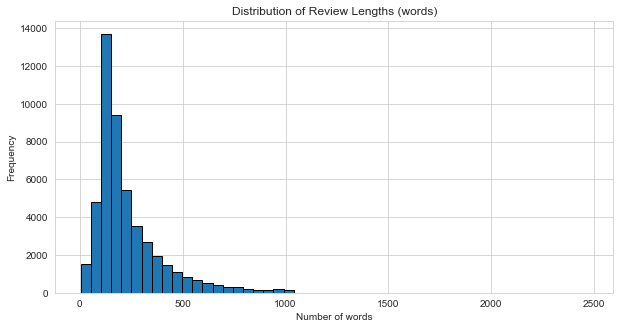

In [7]:
plt.figure(figsize=(10,5))
plt.hist(df['review_length'], bins=50, edgecolor='black')
plt.title("Distribution of Review Lengths (words)")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

Review lengths are skewed → need truncation/padding for neural nets

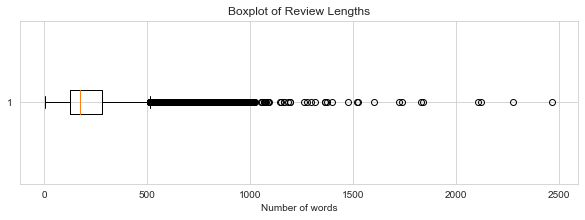

In [8]:
plt.figure(figsize=(10,3))
plt.boxplot(df['review_length'], vert=False)
plt.title("Boxplot of Review Lengths")
plt.xlabel("Number of words")
plt.show()

In [9]:
df = df[df['review_length'] <= 1000].reset_index(drop=True)
print("Shape after removing long reviews:", df.shape)

Shape after removing long reviews: (49500, 3)


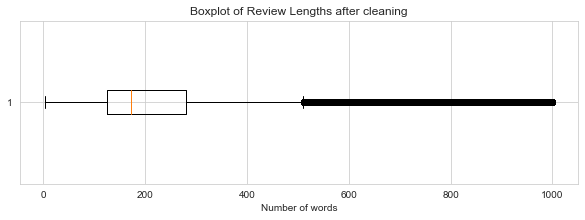

In [10]:
plt.figure(figsize=(10,3))
plt.boxplot(df['review_length'], vert=False)
plt.title("Boxplot of Review Lengths after cleaning")
plt.xlabel("Number of words")
plt.show()

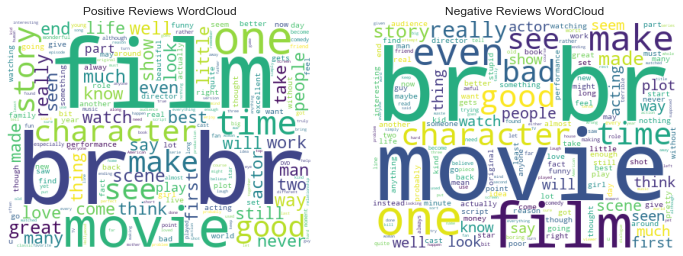

In [11]:
pos_text = " ".join(df[df['sentiment']=='positive']['review'][:2000])
neg_text = " ".join(df[df['sentiment']=='negative']['review'][:2000])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=400, height=300, background_color="white").generate(pos_text))
plt.title("Positive Reviews WordCloud")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=400, height=300, background_color="white").generate(neg_text))
plt.title("Negative Reviews WordCloud")
plt.axis("off")
plt.show()

Sentiment words are strongly present → bag-of-words / TF-IDF will likely perform well.

<AxesSubplot:xlabel='sentiment', ylabel='review_length'>

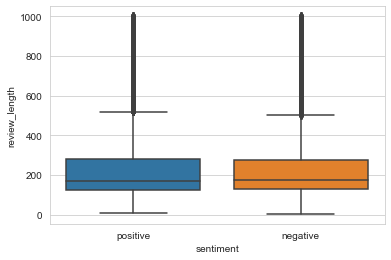

In [12]:
sns.boxplot(x="sentiment", y="review_length", data=df)

/Users/halakhalifa/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1485: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


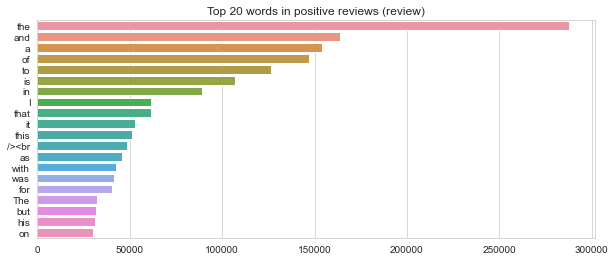

/Users/halakhalifa/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1485: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


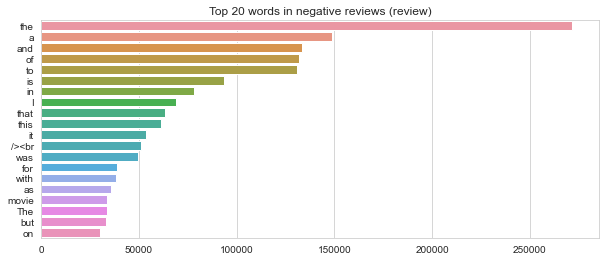

In [13]:
def plot_top_words(sentiment, column="review", n=20):
    words = " ".join(df[df['sentiment'] == sentiment][column]).split()
    counter = Counter(words)
    most_common = counter.most_common(n)
    words, counts = zip(*most_common)
    plt.figure(figsize=(10,4))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(f"Top {n} words in {sentiment} reviews ({column})")
    plt.show()

plot_top_words("positive", column="review")
plot_top_words("negative", column="review")

### Cleaning | test

In [14]:
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = text.lower()
    text = re.sub(f"[{string.punctuation}0-9]", " ", text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    words = [word for word in text.split() if word not in STOPWORDS]
    return " ".join(words)

print("Before:", df['review'][0])
print("After:", clean_text(df['review'][0]))

Before: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to

### Stemming / Lemmatization | test

In [15]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

print("Stemming:", " ".join([stemmer.stem(w) for w in "The runner is running every morning, and he runs fairly easily compared to others".split()]))
print("Lemmatization:", " ".join([lemmatizer.lemmatize(w) for w in "The runner is running every morning, and he runs fairly easily compared to others".split()]))

Stemming: the runner is run everi morning, and he run fairli easili compar to other
Lemmatization: The runner is running every morning, and he run fairly easily compared to others


### Preprocessing Pipeline

In [16]:
def preprocess_pipeline(text, use_stemming=False, use_lemmatization=True):
    # Step 1: Expand contractions
    text = contractions.fix(text)
    
    # Step 2: Clean
    text = BeautifulSoup(text, "html.parser").get_text()
    text = text.lower()
    text = re.sub(f"[{string.punctuation}0-9]", " ", text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Step 3: Tokenize
    tokens = word_tokenize(text)

    # Step 4: Negation handling (join "not good" → "not_good")
    processed_tokens = []
    skip = False
    for i, word in enumerate(tokens):
        if skip:
            skip = False
            continue
        if word == "not" and i+1 < len(tokens):
            processed_tokens.append(f"not_{tokens[i+1]}")
            skip = True
        else:
            processed_tokens.append(word)

    # Step 5: Remove stopwords
    words = [w for w in processed_tokens if w not in STOPWORDS]

    # Step 6: Stem or Lemmatize
    if use_stemming:
        words = [stemmer.stem(w) for w in words]
    elif use_lemmatization:
        words = [lemmatizer.lemmatize(w) for w in words]

    return " ".join(words)

# Apply on dataset
df['clean_review'] = df['review'].apply(preprocess_pipeline)
df[['review', 'clean_review']].head(3)

/Users/halakhalifa/opt/anaconda3/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


,review,clean_review
0,One of the other reviewers has mentioned that ...,one reviewer mentioned watching oz episode hoo...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...


/Users/halakhalifa/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1485: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


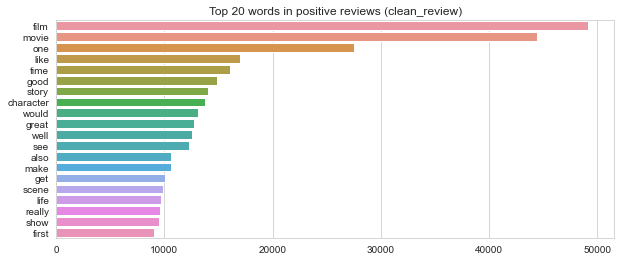

/Users/halakhalifa/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1485: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


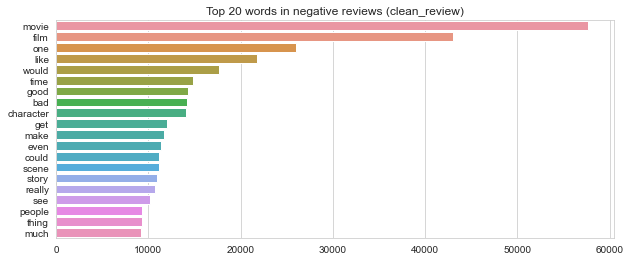

In [17]:
plot_top_words("positive", column="clean_review")
plot_top_words("negative", column="clean_review")

In [18]:
# Save for re-use
df.to_csv("IMDB_cleaned.csv", index=False)

print("Cleaning done. Saved as IMDB_cleaned.csv")

Cleaning done. Saved as IMDB_cleaned.csv


## Phase B: Feature Engineering

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
from gensim.models import Word2Vec

### Train/Test Split

In [20]:
X = df['clean_review']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 39600
Test size: 9900


### Bag-of-Words (CountVectorizer)

In [21]:
bow_vectorizer = CountVectorizer(max_features=10000, ngram_range=(1,2))
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

print("BoW Shape (train):", X_train_bow.shape)
print("BoW Shape (test):", X_test_bow.shape)

BoW Shape (train): (39600, 10000)
BoW Shape (test): (9900, 10000)


### TF-IDF

In [22]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("TF-IDF Shape (train):", X_train_tfidf.shape)
print("TF-IDF Shape (test):", X_test_tfidf.shape)

TF-IDF Shape (train): (39600, 10000)
TF-IDF Shape (test): (9900, 10000)


In [23]:
print("BoW Dimensionality:", X_train_bow.shape[1])
print("TF-IDF Dimensionality:", X_train_tfidf.shape[1])
print("BoW Sparsity:", 1 - (X_train_bow.nnz / np.prod(X_train_bow.shape)))
print("TF-IDF Sparsity:", 1 - (X_train_tfidf.nnz / np.prod(X_train_tfidf.shape)))

BoW Dimensionality: 10000
TF-IDF Dimensionality: 10000
BoW Sparsity: 0.9905654494949495
TF-IDF Sparsity: 0.9905654494949495


In [24]:
# Tokenize for Word2Vec
sentences = [text.split() for text in X_train]

# Train Word2Vec
w2v_model = Word2Vec(sentences, vector_size=200, window=7, min_count=10, workers=4, sg=1, seed=42)
w2v_model.save("w2v_imdb.model")

print("Word2Vec vocabulary size:", len(w2v_model.wv))
for word in ["good", "bad", "fun", "boring"]:
    if word in w2v_model.wv:
        print(f"\nMost similar to '{word}':", w2v_model.wv.most_similar(word)[:10])

Word2Vec vocabulary size: 22835

Most similar to 'good': [('not_brilliant', 0.7060982584953308), ('not_excellent', 0.6814283132553101), ('decent', 0.6745458841323853), ('not_amazing', 0.6693546175956726), ('great', 0.6669386625289917), ('not_spectacular', 0.6537278890609741), ('not_horrible', 0.6450010538101196), ('not_awful', 0.6436232924461365), ('workable', 0.6414764523506165), ('not_complaining', 0.6391667127609253)]

Most similar to 'bad': [('terrible', 0.7028757333755493), ('shitty', 0.6824389696121216), ('not_worse', 0.6809863448143005), ('awful', 0.6807854175567627), ('i´m', 0.6435547471046448), ('horrible', 0.6422858238220215), ('sucky', 0.6401549577713013), ('good', 0.6376377940177917), ('dialouge', 0.6356965899467468), ('atleast', 0.6353104710578918)]

Most similar to 'fun': [('enjoyable', 0.6136855483055115), ('entertaining', 0.5960137844085693), ('poking', 0.5789771676063538), ('zaniness', 0.577637791633606), ('lighten', 0.5762473940849304), ('diverting', 0.572149455547332

In [25]:
import pickle

# Save sparse matrices
with open("X_train_bow.pkl", "wb") as f: pickle.dump(X_train_bow, f)
with open("X_test_bow.pkl", "wb") as f: pickle.dump(X_test_bow, f)
with open("X_train_tfidf.pkl", "wb") as f: pickle.dump(X_train_tfidf, f)
with open("X_test_tfidf.pkl", "wb") as f: pickle.dump(X_test_tfidf, f)

# Save embeddings model
w2v_model.save("imdb_word2vec.model")

print("\n All vectorized data and embeddings saved for reuse.")


 All vectorized data and embeddings saved for reuse.
